## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu' 
from scipy.stats import norm, linregress
#from gpyrn import covfunc, meanfunc, meanfield
import exoplanet as xo
from scipy.optimize import minimize
from scipy.stats import norm
import csv
from scipy import stats
from multiprocessing import Pool
import emcee
import corner
from loguniform import LogUniform, ModifiedLogUniform
import sys
sys.path.append(os.path.abspath("/home/paul/Bureau/IRAP/TediGP"))
import process, kernels, means
from scipy import signal
from tqdm import tqdm
import pandas as pd


np.random.seed(110**2)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load 2 first componant

In [2]:
eigen2vectors = np.load('/home/paul/Bureau/IRAP/dLWPCA/out/TablesAU_MIC/2firstcomponent.npy', allow_pickle=True) #### PATH TO CHANGE ####
times = np.load('/home/paul/Bureau/IRAP/dLWPCA/out/TablesAU_MIC/readyforwPCA_epoc.npy')                          #### PATH TO CHANGE ####

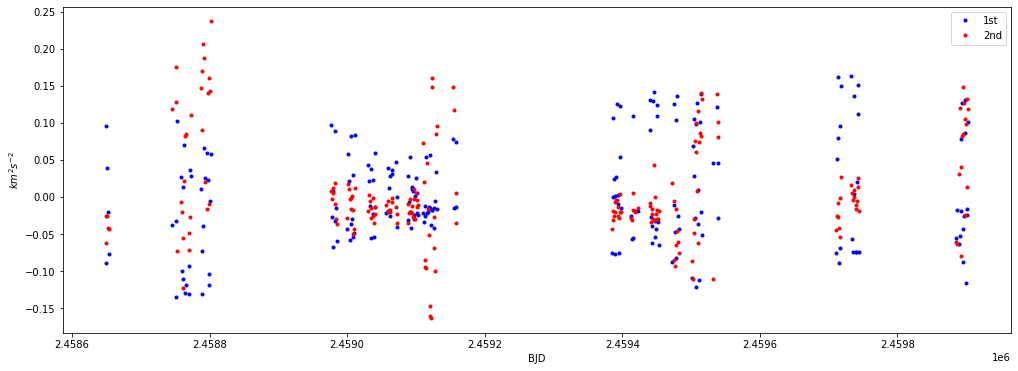

In [3]:
plt.figure(figsize=(17, 6))
plt.plot(times, eigen2vectors[0], 'b.', label='1st')
plt.plot(times, eigen2vectors[1], 'r.', label='2nd')
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
#plt.plot(times[:-1], eigen2vectors[3], 'r.')

plt.show()

## Periodograms
### 1st component

Peak frequency = 
4.872036928043502


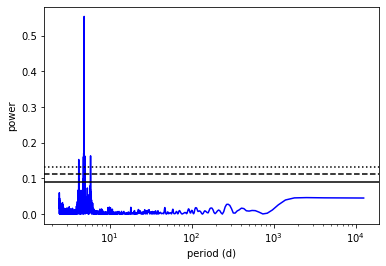

In [4]:
frequency, power = LombScargle(times, eigen2vectors[0]).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'b')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times, eigen2vectors[0])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

### 2nd component

Peak frequency = 
379.87124290472514


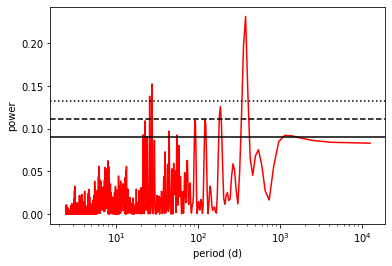

In [5]:
frequency, power = LombScargle(times, eigen2vectors[1]).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'r')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times, eigen2vectors[1])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

## First component GP

Just to recall the GP uses a Quasi-Periodic covariance function that is build that way:


$K_{ij} = \eta_1^2 \, \exp \left[- \frac{(t_i - t_j)^2}{2 \eta_2^2} - \frac{2 }{\eta_4^2} \sin^2 \left( \frac{\pi (t_i - t_j)}{\eta_3} \right) \right] + Jitter$ 

In [12]:
print(2*(np.max(eigen2vectors[0])- np.min(eigen2vectors[0])))
print(np.std(eigen2vectors[0]))
print(10*(np.max(times)-np.min(times)))


0.5967559470595729
0.06943996753537869
12535.75101585593


For the Prior distribution, I use : 

$\eta_1 : \mathcal{MLU}\left( y_\sigma , 2 \times y_{ptp} \right)$

$\eta_2 : \mathcal{LU}\left( 1 , 10 \times t_{total} \right)$

$\eta_3 : \mathcal{N}\left( P , 0.1 \right)$

$\eta_4 : \mathcal{LU}\left( 0.1, 5 \right)$

$Jitter : \mathcal{MLU}\left( y_\sigma , 2 \times y_{ptp} \right)$

In [13]:
#Priors
n_eta1 = ModifiedLogUniform(0.07, 0.6)
n_eta2 = stats.loguniform(1, 12565)
n_eta3 = stats.norm(loc=4.865, scale=0.1)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.07, 0.6)

In [14]:
def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

In [15]:
def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[0]))
    gpOBJ = process.GP(kernel,mean,times,eigen2vectors[0], yerr = 1e-12 * np.identity(times.size))
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

In [16]:
ndim = priors().size 
nwalkers = 2*ndim

In [17]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [06:08<00:00, 27.12it/s]


State([[6.95961467e-02 1.41935415e+02 4.86452175e+00 9.02257494e-01
  8.77731430e-03]
 [6.87673640e-02 1.45110221e+02 4.85845102e+00 8.83825632e-01
  7.12645099e-03]
 [5.99316694e-02 1.49940007e+02 4.86132521e+00 8.18093398e-01
  6.93341195e-03]
 [7.01455142e-02 1.45600233e+02 4.86486404e+00 8.11982284e-01
  6.61704992e-03]
 [5.81985398e-02 1.32749581e+02 4.85712477e+00 6.62340710e-01
  6.90095900e-03]
 [6.53756441e-02 1.56910340e+02 4.85961311e+00 8.50524276e-01
  8.89629704e-03]
 [6.17409289e-02 1.53487535e+02 4.86495230e+00 8.36251425e-01
  7.59418181e-03]
 [6.75518500e-02 1.43593264e+02 4.86396990e+00 9.26687178e-01
  7.67249947e-03]
 [6.26849278e-02 1.63572013e+02 4.86313055e+00 7.22018856e-01
  8.14810390e-03]
 [6.44463994e-02 1.50487738e+02 4.85898281e+00 9.65295480e-01
  8.74433384e-03]], log_prob=[567.66760532 569.26356    569.61001784 567.99869027 564.37739379
 567.54924929 569.68490829 570.08007825 568.3533698  565.75310066], blobs=None, random_state=('MT19937', array([16756

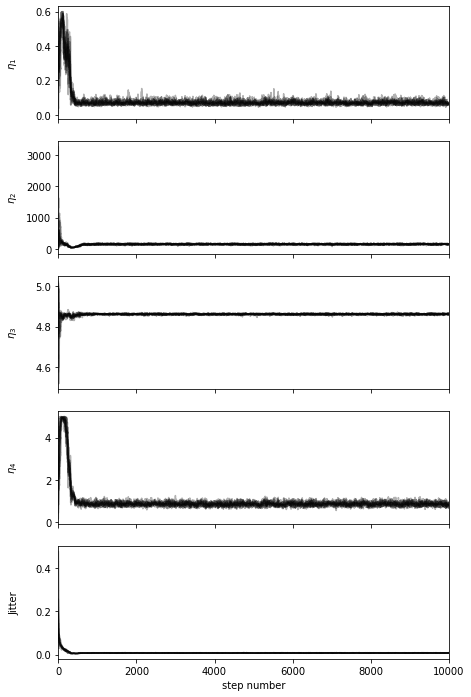

In [18]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

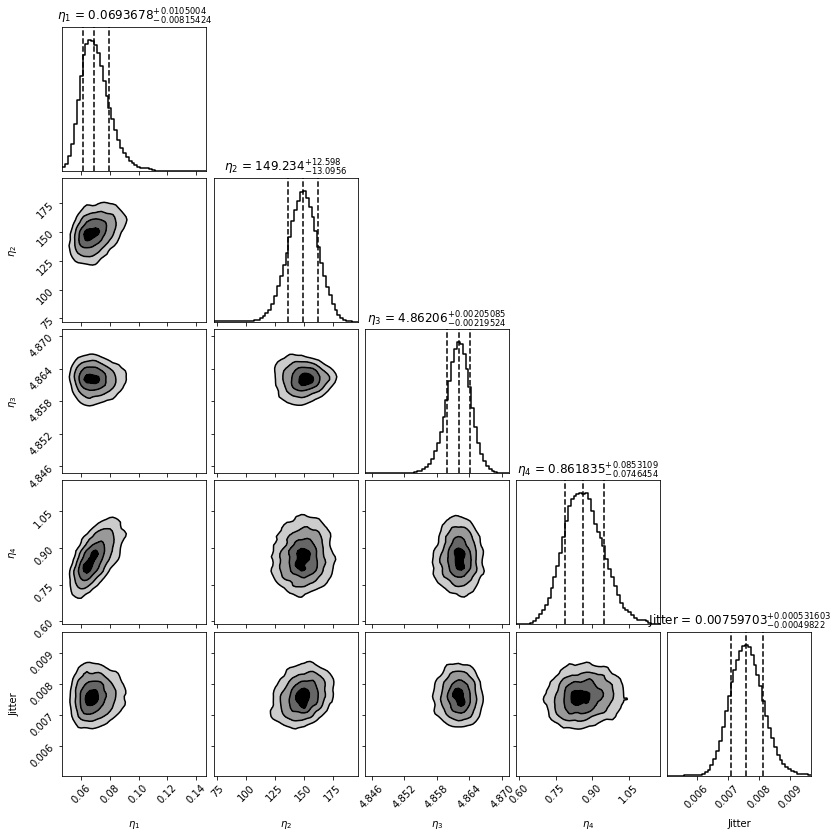

In [19]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False, title_fmt='g')
plt.show()

In [20]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[0]))
    gpOBJ = process.GP(kernel,mean,times,eigen2vectors[0],yerr = 1e-12 * np.identity(times.size))
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

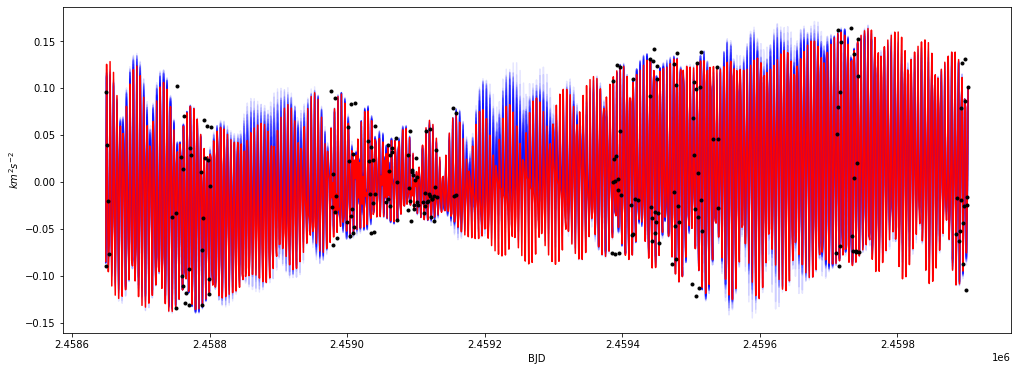

In [22]:
plt.figure(figsize=(17, 6))
tplot = np.linspace(np.min(times), np.max(times), 1000)

for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.plot(times, eigen2vectors[0],'k.')
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()

100%|██████████| 15/15 [01:30<00:00,  6.04s/it]


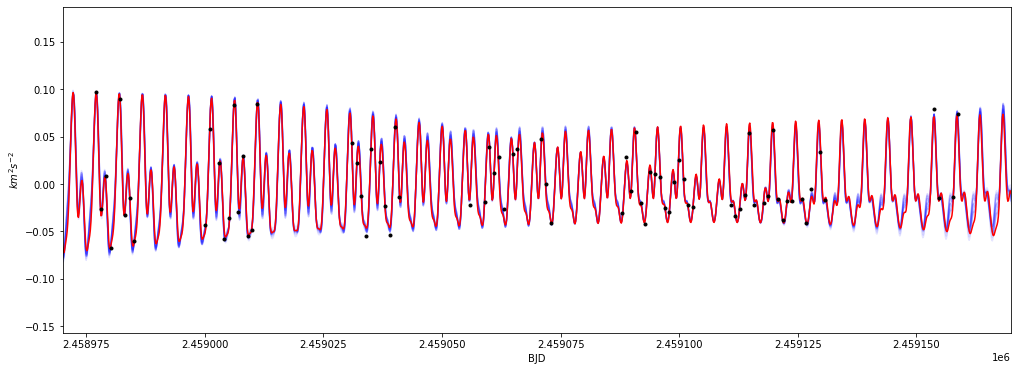

In [23]:
plt.figure(figsize=(17, 6))
tplot = np.linspace(np.min(times), np.max(times), 10000)

for s in tqdm(range(15)):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.plot(times, eigen2vectors[0],'k.')
plt.xlim([-30+2459000, 170+2459000])
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()

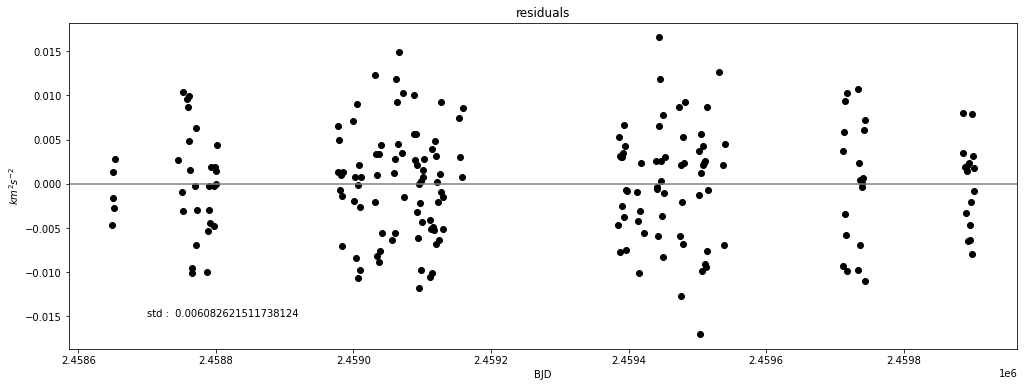

In [25]:
y_sample = Display(Hfit, times)

residuals = eigen2vectors[0] - y_sample
plt.figure(figsize=(17, 6))
plt.plot(times, residuals, 'ok')
plt.axhline(y=0, c='grey')
plt.annotate( "std :  " + str(np.std(residuals)), (2.4587*1e6, -0.015) )
plt.title('residuals')
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()

# Compares with Donati et al. (submitted)
## Load Data

In [26]:
B_table = np.loadtxt('/media/paul/One Touch2/SPIRou_Data/AU_MIC/B.txt')


times_W, W1, dW1, W2, dW2, W3, dW3, W4, dW4, W5, dW5 = np.loadtxt('/media/paul/One Touch2/SPIRou_Data/AU_MIC/AUMIC_DLW_PCA_units.rdb',
                   usecols=(0,1,2,3,4,5,6,7,8,9,10),skiprows=2, dtype=str, unpack=True)

times_W = np.array(times_W.astype(float))
W1 = np.array(W1.astype(float))
W2 = np.array(W2.astype(float))
W3 = np.array(W3.astype(float))
W4 = np.array(W4.astype(float))
W5 = np.array(W5.astype(float))
dW1 = np.array(dW1.astype(float))
dW2 = np.array(dW2.astype(float))
dW3 = np.array(dW3.astype(float))
dW4 = np.array(dW4.astype(float))
dW5 = np.array(dW5.astype(float))


times_pca = times - 2459000
times_B = B_table[:,0]
B = B_table[:,1]
dB = B_table[:,2]

## Magnetic Field B

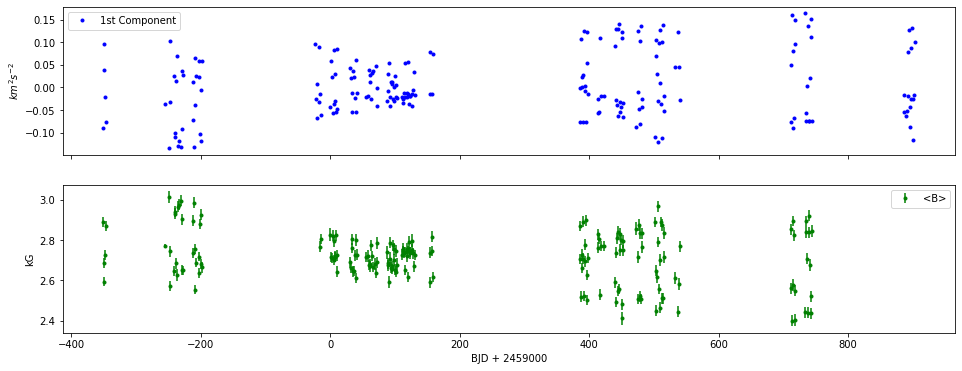

In [28]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(211)
plt.plot(times_pca, eigen2vectors[0], 'b.', label='1st Component')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
plt.tick_params('x', labelbottom=False)


# share x and y
ax3 = plt.subplot(212, sharex=ax1)
plt.errorbar(times_B, B, yerr=dB, fmt='.g', label='<B>')
plt.xlabel('BJD + 2459000')
plt.ylabel('kG')
plt.legend()
plt.show()


Peak frequency = 
4.872610970182465


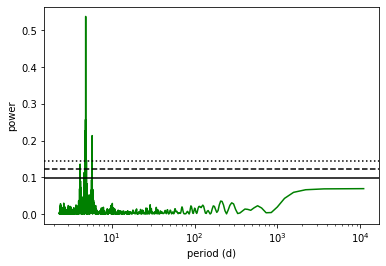

In [29]:
frequency, power = LombScargle(times_B, B).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'g')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times_B, B)

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

###  B GP

In [30]:
print(2*(np.max(B)- np.min(B)))
print(np.std(B))
print(10*(np.max(times_B)-np.min(times_B)))

1.2224000000000004
0.12771711650555842
10948.75685


In [31]:
#Priors
n_eta1 = ModifiedLogUniform(0.12, 1.2)
n_eta2 = stats.loguniform(1, 11000)
n_eta3 = stats.norm(loc=4.865, scale=0.1)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.12, 1.2)

In [32]:
def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(B))
    gpOBJ = process.GP(kernel,mean,times_B,B, yerr = dB)
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

In [33]:
ndim = priors().size 
nwalkers = 2*ndim

sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [04:55<00:00, 33.90it/s]


State([[1.49873315e-01 1.41145147e+02 4.85945306e+00 1.22603129e+00
  2.82222468e-04]
 [1.92207652e-01 1.48765248e+02 4.85391936e+00 1.78266951e+00
  8.47766681e-03]
 [1.43550566e-01 1.53246425e+02 4.85844054e+00 1.31448642e+00
  7.99089529e-03]
 [1.48372004e-01 1.41831402e+02 4.85614403e+00 1.18665136e+00
  7.95688628e-03]
 [2.01427405e-01 1.64666281e+02 4.85352047e+00 1.59235226e+00
  7.06000104e-03]
 [2.16442624e-01 1.50590150e+02 4.85835635e+00 1.71637753e+00
  2.88976740e-03]
 [1.43178152e-01 2.08500184e+02 4.86091807e+00 1.20005947e+00
  1.59936886e-03]
 [1.74101350e-01 1.40244531e+02 4.86330184e+00 1.22740018e+00
  1.26869634e-02]
 [1.44340102e-01 1.49363729e+02 4.85655754e+00 1.50229721e+00
  3.76227731e-03]
 [1.95749701e-01 1.36068282e+02 4.85722620e+00 1.73235088e+00
  1.60334526e-02]], log_prob=[329.07751826 326.41214413 328.97118076 327.91265356 326.79356921
 327.30393657 326.36528587 324.87888242 327.9255968  323.57561022], blobs=None, random_state=('MT19937', array([16756

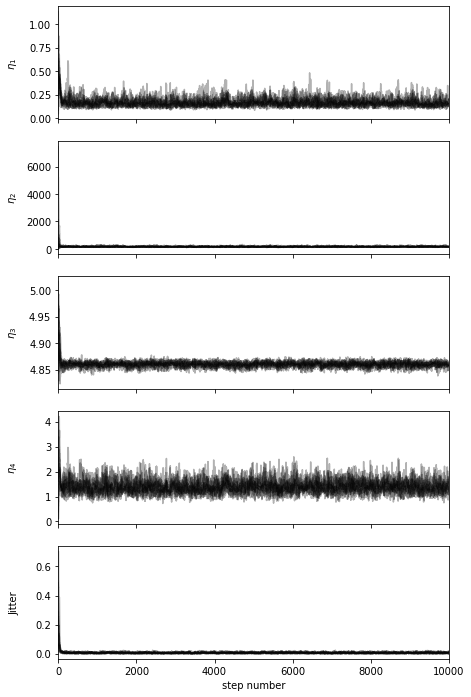

In [34]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

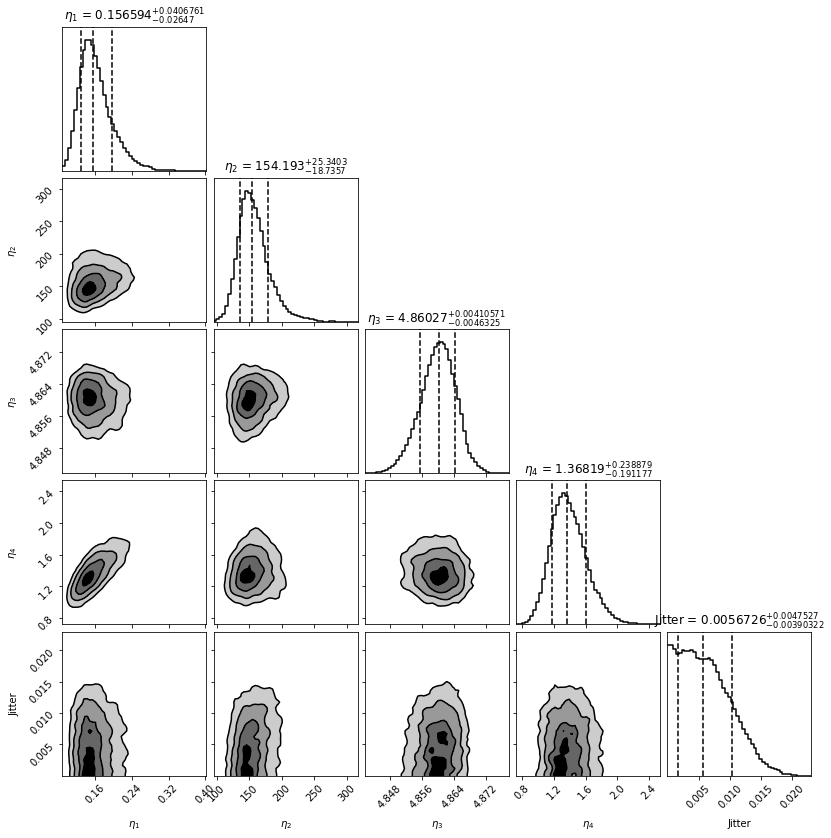

In [35]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False, title_fmt='g')
plt.show()

#### On retrouve l'exact même résultat que Donati et al. (Submitted) ! 

In [36]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(B))
    gpOBJ = process.GP(kernel,mean,times_B,B,yerr = dB)
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

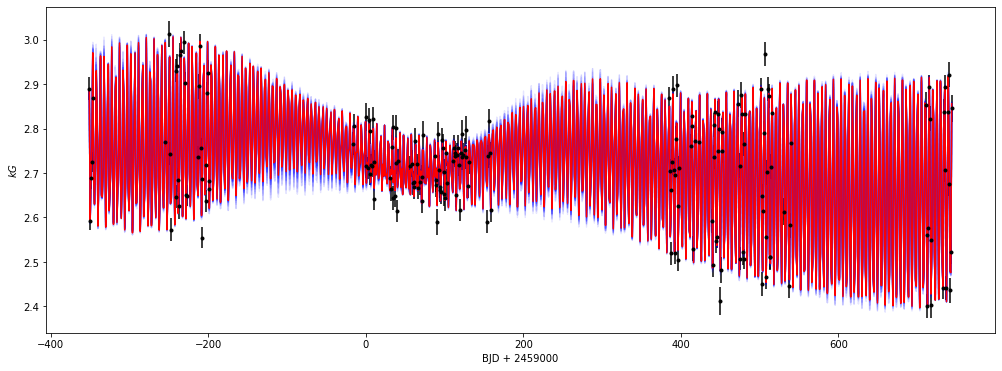

In [37]:
plt.figure(figsize=(17, 6))
tplot = np.linspace(times_B[0], times_B[-1], 1000)

for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.errorbar(times_B, B, yerr=dB, fmt='k.')
plt.xlabel('BJD + 2459000')
plt.ylabel('$kG$')
plt.show()

100%|██████████| 15/15 [01:27<00:00,  5.82s/it]


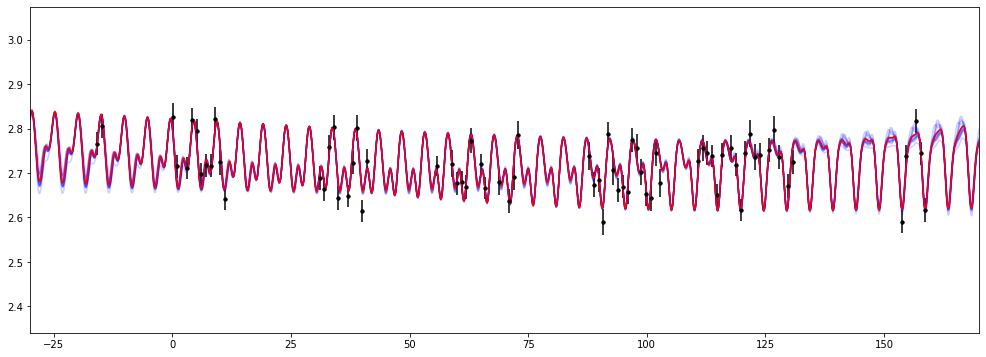

In [38]:
plt.figure(figsize=(17, 6))

plt.plot(times_B, B,'k.')
tplot = np.linspace(np.min(times_B), np.max(times_B), 10000)
 
for s in tqdm(range(15)):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.2)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.errorbar(times_B, B, yerr=dB, fmt='k.')
plt.xlim([-30,170])
plt.show()

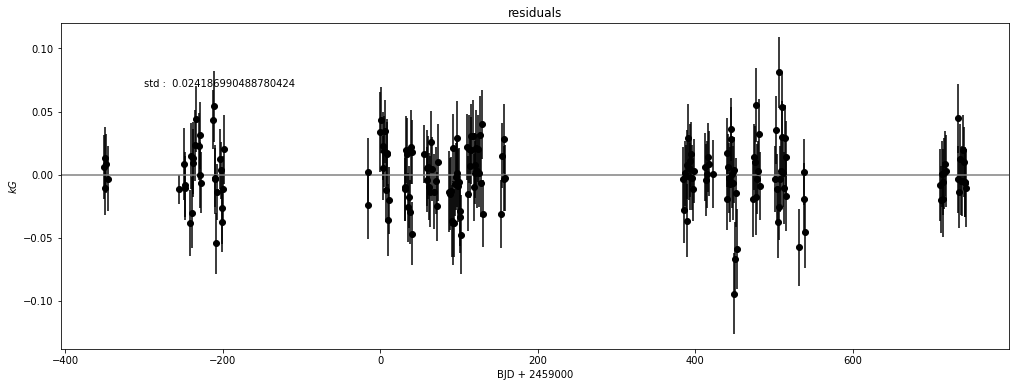

In [39]:
y_sample = Display(Hfit, times_B)

residuals = B - y_sample
plt.figure(figsize=(17, 6))
plt.errorbar(times_B, residuals, yerr=dB, fmt='ok')
plt.annotate( "std :  " + str(np.std(residuals)), (-300, 0.07) )
plt.axhline(y=0, c='grey')
plt.title('residuals')
plt.xlabel('BJD + 2459000')
plt.ylabel('$kG$')
plt.show()

### Correlation Coef

In [40]:
df1 = pd.DataFrame(dict(x=eigen2vectors[0]))

CORR_VALS = np.array(B)
def get_correlation(vals):
    return stats.pearsonr(vals, CORR_VALS)[0]

df1['correlation'] = df1.rolling(window=len(CORR_VALS)).apply(get_correlation)



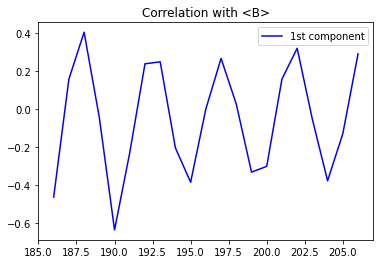

-0.6364798702878474


In [45]:
plt.plot(df1['correlation'].values, 'b', label='1st component')
plt.legend()
plt.title('Correlation with <B>')
plt.show()
print(np.nanmin(df1['correlation'].values))

## W1 

In [46]:
BJDtoRJD = times_W[1] - np.min(times_pca)

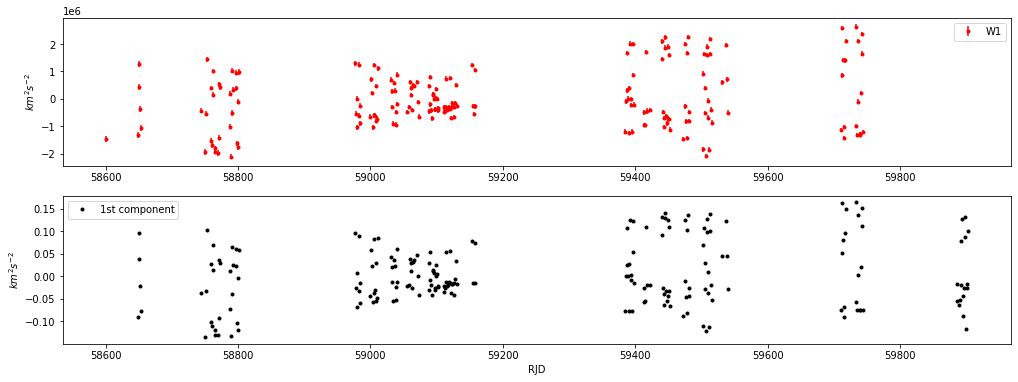

In [47]:
plt.figure(figsize=(17, 6))
ax1 = plt.subplot(211)
plt.errorbar(times_W, W1, yerr=dW1, fmt='.r', label='W1')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()

# share x and y
ax2 = plt.subplot(212, sharex=ax1)
plt.plot(times_pca + BJDtoRJD, eigen2vectors[0], '.k', label='1st component')
plt.xlabel('RJD')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
plt.show()


Peak frequency = 
4.873785050046695


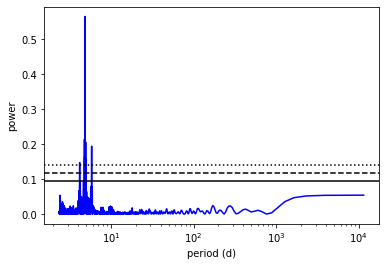

In [17]:
frequency, power = LombScargle(times_W, W1).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'b')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times_W, W1)

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

### Correlation Coef

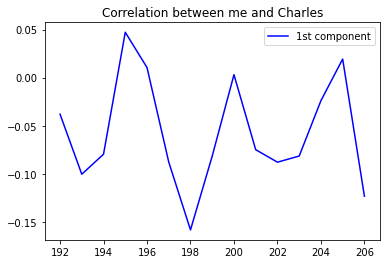

-0.15831603759545376


In [49]:
df1 = pd.DataFrame(dict(x=eigen2vectors[1]))

CORR_VALS = np.array(W1)
def get_correlation(vals):
    return stats.pearsonr(vals, CORR_VALS)[0]

df1['correlation'] = df1.rolling(window=len(CORR_VALS)).apply(get_correlation)

plt.plot(df1['correlation'].values, 'b', label='1st component')
plt.legend()
plt.title('Correlation between me and Charles')
plt.show()
print(np.nanmin(df1['correlation'].values))

### GP Charles
#### First component

In [50]:
print(2*(np.max(W1)- np.min(W1)))
print(np.std(W1))
print(10*(np.max(times_W)-np.min(times_W)))

9488407.474691853
1079723.4905268278
11438.773512459593


In [51]:
#Priors
n_eta1 = ModifiedLogUniform(900000, 2500000)
n_eta2 = stats.loguniform(1, 1255)
n_eta3 = stats.norm(loc=4.865, scale=0.05)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(1, 1000000)

def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(W1))
    gpOBJ = process.GP(kernel,mean,times_W,W1, yerr = dW1)
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

ndim = priors().size 
nwalkers = 2*ndim

sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [04:55<00:00, 33.88it/s]


State([[8.79044538e+05 1.42758061e+02 4.85587246e+00 7.59221040e-01
  9.53392612e+04]
 [1.07103004e+06 1.41701381e+02 4.86166917e+00 9.16206394e-01
  9.38903402e+04]
 [1.20318678e+06 1.51626782e+02 4.85890262e+00 8.18051271e-01
  8.63048870e+04]
 [1.20525425e+06 1.40245033e+02 4.85856009e+00 8.10706629e-01
  9.62921568e+04]
 [1.21708351e+06 1.46619833e+02 4.86200427e+00 9.81700301e-01
  1.09099279e+05]
 [9.43555210e+05 1.49831163e+02 4.86099901e+00 8.63605865e-01
  1.12763514e+05]
 [9.87967780e+05 1.25984876e+02 4.85817941e+00 8.72620833e-01
  8.76187715e+04]
 [9.20579517e+05 1.29612430e+02 4.85900043e+00 6.83993858e-01
  1.05098522e+05]
 [1.07921760e+06 1.42601997e+02 4.85870668e+00 9.01944386e-01
  7.91809236e+04]
 [1.10214838e+06 1.64231946e+02 4.86276808e+00 8.92292471e-01
  1.12268758e+05]], log_prob=[-2708.5740836  -2707.89379186 -2708.74173168 -2709.09441559
 -2708.8263853  -2708.0399027  -2708.30447548 -2710.74912285
 -2709.02003008 -2709.28406996], blobs=None, random_state=('M

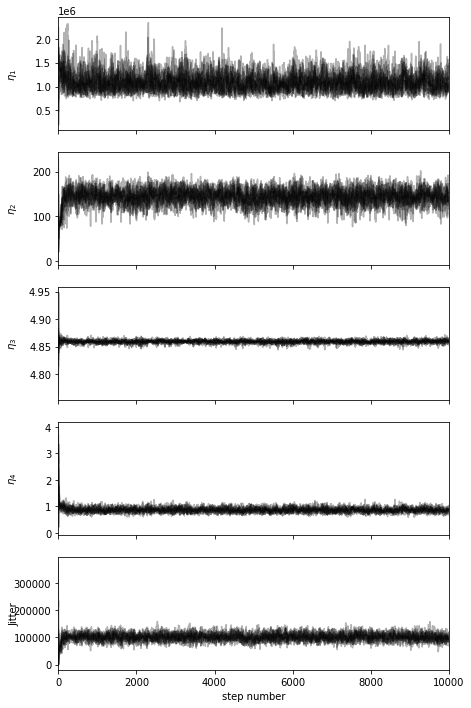

In [52]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

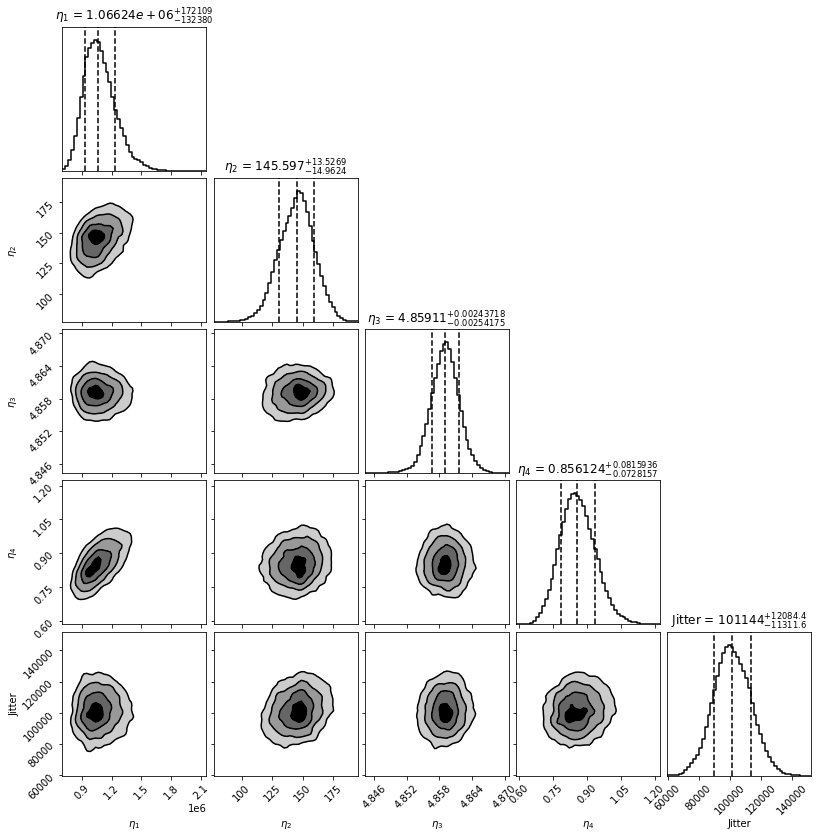

In [53]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False, title_fmt='g')
plt.show()

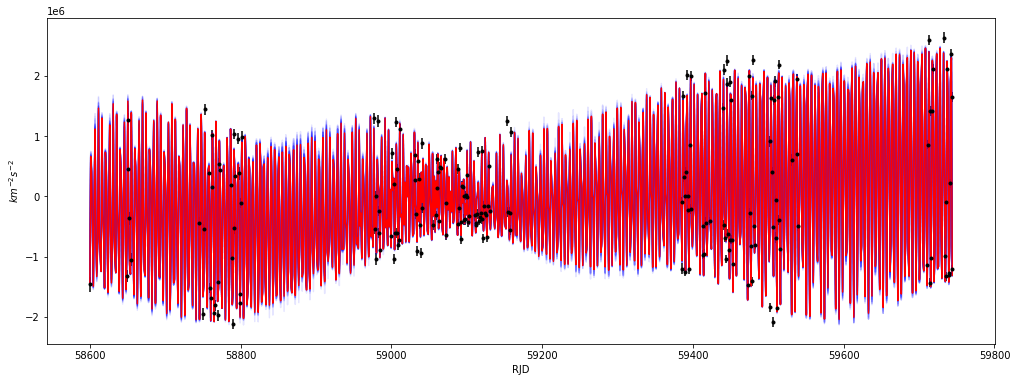

In [54]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(W1))
    gpOBJ = process.GP(kernel,mean,times_W, W1,yerr = dW1)
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

plt.figure(figsize=(17, 6))
tplot = np.linspace(times_W[0], times_W[-1], 1000)

for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.errorbar(times_W, W1, yerr=dW1, fmt='k.')
plt.xlabel('RJD')
plt.ylabel('$km^{-2}s^{-2}$')
plt.show()

100%|██████████| 15/15 [01:34<00:00,  6.30s/it]


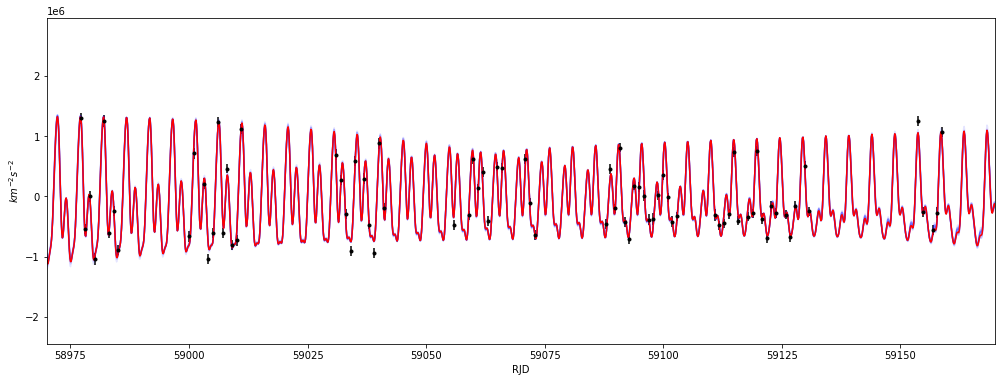

In [55]:
plt.figure(figsize=(17, 6))
tplot = np.linspace(times_W[0], times_W[-1], 10000)

for s in tqdm(range(15)):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.errorbar(times_W, W1, yerr=dW1, fmt='k.')
plt.xlabel('RJD')
plt.ylabel('$km^{-2}s^{-2}$')
plt.xlim([-30 + BJDtoRJD, 170 + BJDtoRJD])
plt.show()

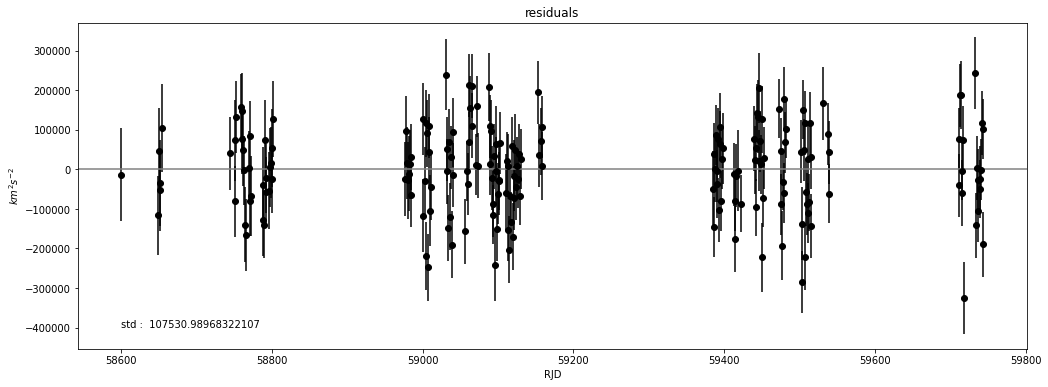

In [58]:
y_sample = Display(Hfit, times_W)

residuals = W1 - y_sample
plt.figure(figsize=(17, 6))
plt.errorbar(times_W, residuals, yerr=dW1, fmt='ok')
plt.annotate( "std :  " + str(np.std(residuals)), (58600, -400000) )
plt.axhline(y=0, c='grey')
plt.title('residuals')
plt.xlabel('RJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()

## RV first derivative

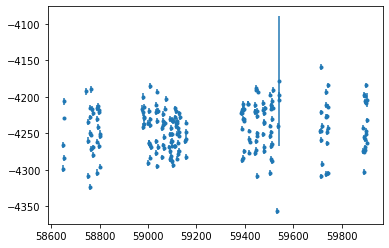

In [59]:
times_RV, RV, dRV = np.loadtxt('/media/paul/One Touch2/SPIRou_Data/AU_MIC/lbl2_AUMIC_AUMIC.rdb',
                   usecols=(0,1,2),skiprows=2, dtype=str, unpack=True)

times_RV = np.array(times_RV.astype(float))
RV = np.array(RV.astype(float))
dRV = np.array(dRV.astype(float))

plt.errorbar(times_RV, RV, yerr=dRV, fmt='.')
plt.show()

Peak frequency = 
4.872250163692677


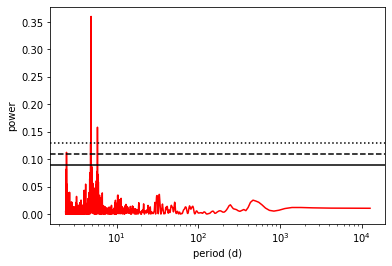

In [60]:
frequency, power = LombScargle(times_RV, RV).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'r')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times_RV, RV)

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

In [61]:
print(2*(np.max(RV)- np.min(RV)))
print(np.std(RV))
print(10*(np.max(times_RV)-np.min(times_RV)))

393.82589078008095
32.08497830033583
12565.533172163414


In [62]:
#Priors
n_eta1 = ModifiedLogUniform(30, 400)
n_eta2 = stats.loguniform(1, 10000)
n_eta3 = stats.norm(loc=4.865, scale=0.05)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(1, 500)

def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(RV))
    gpOBJ = process.GP(kernel,mean,times_RV,RV, yerr = dRV)
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

ndim = priors().size 
nwalkers = 2*ndim

sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [05:27<00:00, 30.54it/s]


State([[ 32.78175378 116.78607294   4.8558196    0.64844281  13.14555805]
 [ 31.92831206 167.85131228   4.87114095   0.68472602  13.70124921]
 [ 34.80969081 138.58062485   4.87033181   0.64669991  12.76580847]
 [ 32.80053717 132.46147663   4.86140901   0.57477679  12.63408765]
 [ 25.30324165 129.18718138   4.86594071   0.63312313  13.80142054]
 [ 26.81254741 122.29688433   4.87229651   0.58177058  12.6148609 ]
 [ 32.01618429 140.18730704   4.86866136   0.72306908  14.03648496]
 [ 36.12850606 148.28142766   4.86634335   0.57910497  12.08338392]
 [ 30.10131622 141.30912179   4.86844192   0.63522019  14.36943182]
 [ 26.15077019 162.40333658   4.86789339   0.66272105  12.29584719]], log_prob=[-942.57935133 -939.33840224 -938.91072978 -940.98343079 -939.93951708
 -939.45219956 -938.98301412 -940.02966463 -939.12933455 -940.388421  ], blobs=None, random_state=('MT19937', array([1675638942,  460824137,  694651535, 1023551861, 1419539384,
       3601489963,  465570902, 1500557938, 1986231021, 

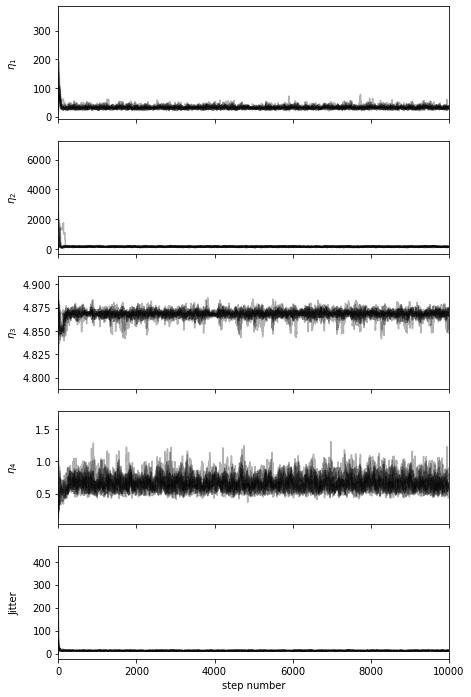

In [63]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

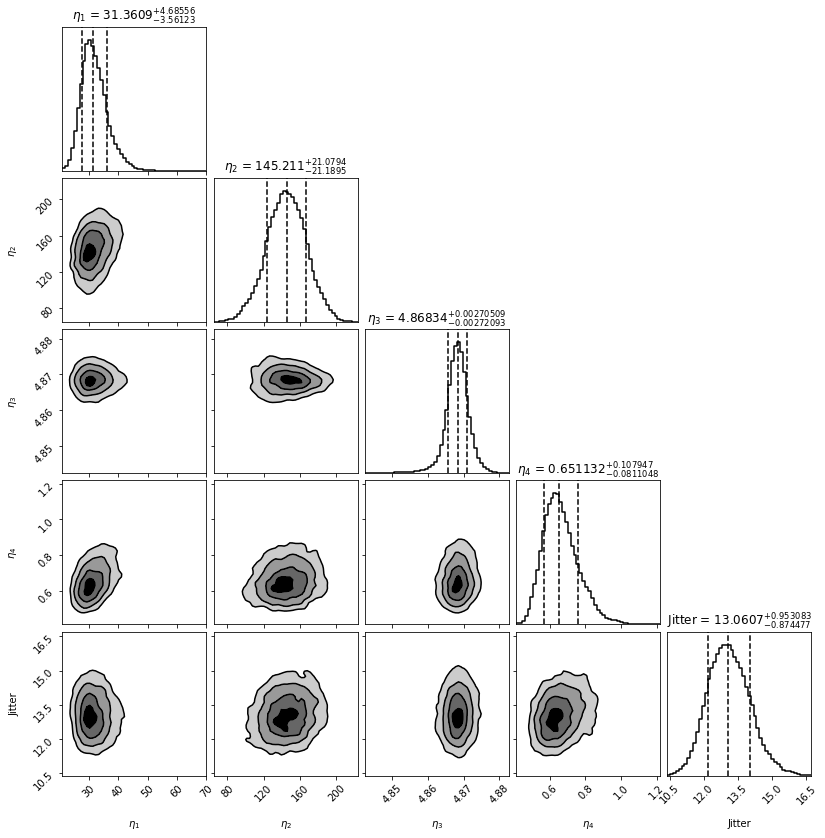

In [64]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False, title_fmt='g')
plt.show()

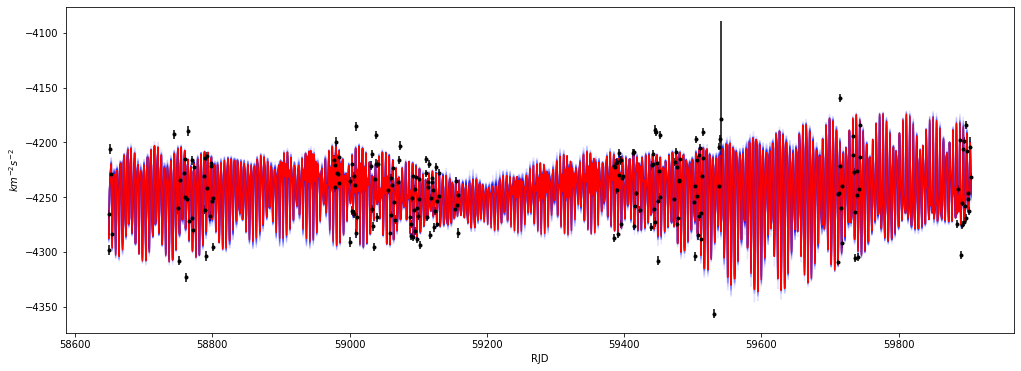

In [65]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(RV))
    gpOBJ = process.GP(kernel,mean,times_RV, RV,yerr = dRV)
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

plt.figure(figsize=(17, 6))
tplot = np.linspace(times_RV[0], times_RV[-1], 1000)

for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.errorbar(times_RV, RV, yerr=dRV, fmt='k.')
plt.xlabel('RJD')
plt.ylabel('$km^{-2}s^{-2}$')
plt.show()

100%|██████████| 15/15 [01:37<00:00,  6.52s/it]


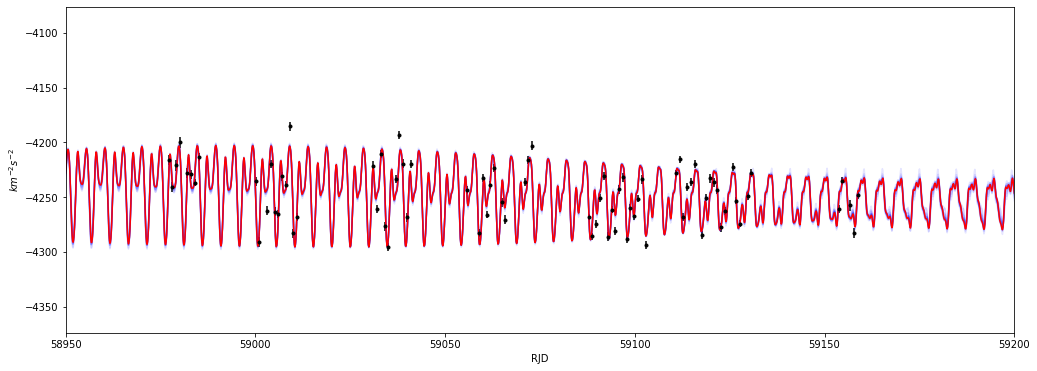

In [68]:
plt.figure(figsize=(17, 6))
tplot = np.linspace(times_RV[0], times_RV[-1], 10000)

for s in tqdm(range(15)):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.errorbar(times_RV, RV, yerr=dRV, fmt='k.')
plt.xlabel('RJD')
plt.ylabel('$km^{-2}s^{-2}$')
plt.xlim([58950, 59200])
plt.show()

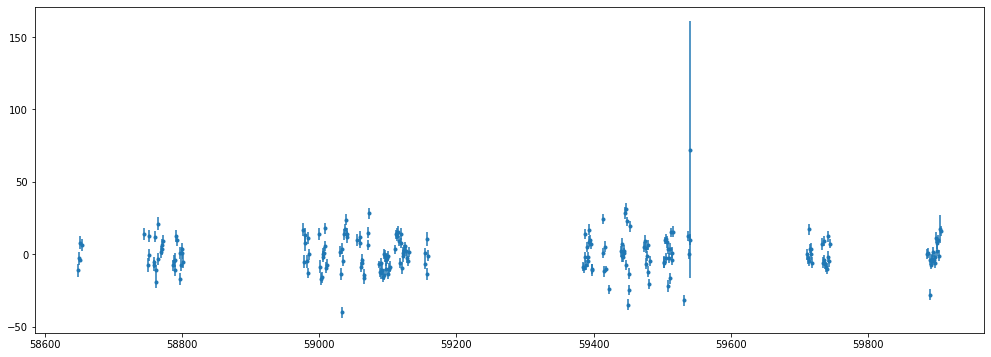

In [67]:
res_RV = RV - Display(flat_samples[s,:], times_RV)
plt.figure(figsize=(17, 6))
plt.errorbar(times_RV, res_RV, yerr=dRV, fmt='.')
plt.show()

Peak frequency = 
33.15444108750241


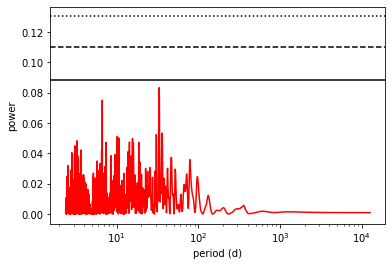

In [69]:
frequency, power = LombScargle(times_RV, res_RV).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'r')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times_RV, res_RV)

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

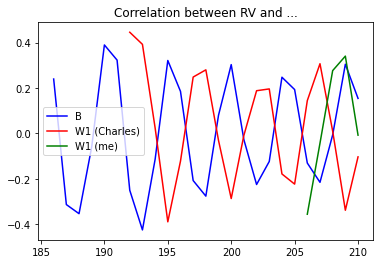

0.38968091718811426 0.4456275808048775 0.34053574021526667
-0.4245917725868351 -0.38897949726097214 -0.3555030751536262


In [80]:
df1 = pd.DataFrame(dict(x=RV))


CORR_VALS = np.array(B)
def get_correlation(vals):
    return stats.pearsonr(vals, CORR_VALS)[0]

df1['correlation'] = df1.rolling(window=len(CORR_VALS)).apply(get_correlation)

df2 = pd.DataFrame(dict(x=RV))

CORR_VALS = np.array(W1)
def get_correlation(vals):
    return stats.pearsonr(vals, CORR_VALS)[0]

df2['correlation'] = df2.rolling(window=len(CORR_VALS)).apply(get_correlation)

df3 = pd.DataFrame(dict(x=RV))

CORR_VALS = np.array(eigen2vectors[0])
def get_correlation(vals):
    return stats.pearsonr(vals, CORR_VALS)[0]

df3['correlation'] = df3.rolling(window=len(CORR_VALS)).apply(get_correlation)


plt.plot(df1['correlation'].values, 'b', label='B')
plt.plot(df2['correlation'].values, 'r', label='W1 (Charles)')
plt.plot(df3['correlation'].values, 'g', label='W1 (me)')
plt.title('Correlation between RV and ...')
plt.legend()
plt.show()

print(np.nanmax(df1['correlation'].values),np.nanmax(df2['correlation'].values),np.nanmax(df3['correlation'].values))
print(np.nanmin(df1['correlation'].values),np.nanmin(df2['correlation'].values),np.nanmin(df3['correlation'].values))


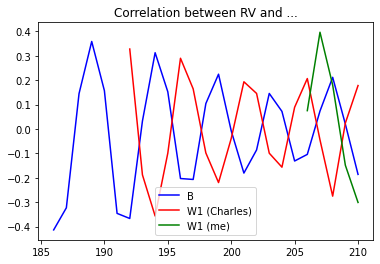

0.3586001266561026 0.32765057115663204 0.39642163320841994
-0.4134518988085448 -0.3563645179303008 -0.3009330054298097


In [81]:
dRVdt = np.gradient(RV, times_RV)

df1 = pd.DataFrame(dict(x=dRVdt))


CORR_VALS = np.array(B)
def get_correlation(vals):
    return stats.pearsonr(vals, CORR_VALS)[0]

df1['correlation'] = df1.rolling(window=len(CORR_VALS)).apply(get_correlation)

df2 = pd.DataFrame(dict(x=dRVdt))

CORR_VALS = np.array(W1)
def get_correlation(vals):
    return stats.pearsonr(vals, CORR_VALS)[0]

df2['correlation'] = df2.rolling(window=len(CORR_VALS)).apply(get_correlation)

df3 = pd.DataFrame(dict(x=dRVdt))

CORR_VALS = np.array(eigen2vectors[0])
def get_correlation(vals):
    return stats.pearsonr(vals, CORR_VALS)[0]

df3['correlation'] = df3.rolling(window=len(CORR_VALS)).apply(get_correlation)


plt.plot(df1['correlation'].values, 'b', label='B')
plt.plot(df2['correlation'].values, 'r', label='W1 (Charles)')
plt.plot(df3['correlation'].values, 'g', label='W1 (me)')
plt.title('Correlation between RV and ...')
plt.legend()
plt.show()

print(np.nanmax(df1['correlation'].values),np.nanmax(df2['correlation'].values),np.nanmax(df3['correlation'].values))
print(np.nanmin(df1['correlation'].values),np.nanmin(df2['correlation'].values),np.nanmin(df3['correlation'].values))
